# Interferometric observations of NGC 1068

In [143]:
#3rd party
from __future__ import print_function
from astropy.modeling import models
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from copy import copy
import os as os
from importlib import reload
import astropy.io.fits as fits

#HyperCAT
import sys
sys.path.append('../hypercat/')
import hypercat as hc
import interferometry as inter
import ioops as io
import ndiminterpolation

In [ ]:
def plot_inter(sky,fftscale,u,v,corrflux,BL):
    ### Figures
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,3))

    #Image
    xx1 = np.linspace(sky.npix//2*(-1.*sky.pixelscale.value),\
                  sky.npix//2*(sky.pixelscale.value),\
                  sky.npix)

    aa = np.log10(sky.data.T.value*1000.+1E-6)
    levels = np.linspace(np.min(aa[aa>-6]),np.max(aa),21)
    cbar1 = ax1.contourf(xx1,xx1,aa,levels=levels)
    plt.colorbar(cbar1,label='log(Flux [mJy])',ax=ax1)
    ax1.set_ylim([np.min(xx1),np.max(xx1)])
    ax1.set_xlim([np.min(xx1),np.max(xx1)])
    ax1.set_xlabel('Offset (mas)')
    ax1.set_ylabel('Offset (mas)')

    #Image in FFT space
    pixscale_masmet = fftscale/sky.pixelscale.value
    xx2 = np.linspace(sky.npix//2*(-fftscale),\
                  sky.npix//2*(fftscale),\
                  sky.npix)
    cbar = ax2.contourf(xx2,xx2,np.log10(np.abs(ori_fft)/np.max(np.abs(ori_fft))),51)
    plt.colorbar(cbar,label='Normalized flux',ax=ax2)
    ax2.set_ylim([-150,150])
    ax2.set_xlim([150,-150])
    ax2.set_xlabel('u (m)')
    ax2.set_ylabel('v (m)')

    #uv plave vs. correlated flux
    cbar=ax3.scatter(u,v,c = np.log10(corrflux),s=50,linewidths=0)
    plt.colorbar(cbar,label='$\log$ (F$_{corr}$)',ax=ax3)
    ax3.set_ylim([-150,150])
    ax3.set_xlim([150,-150])
    ax3.set_ylabel('v [m]',fontsize=10)
    ax3.set_xlabel('u [m]',fontsize=10)
    ax3.axvline(0,linestyle='--',color='black',linewidth=0.5)
    ax3.axhline(0,linestyle='--',color='black',linewidth=0.5)

    #Correlated flux vs. Baseline vs. PA
    cbar = ax4.scatter(BL,corrflux,c = Phi,s=50,linewidths=0)
    #plt.plot(0,sky.data.value.sum(),'x',color='black')
    plt.colorbar(cbar,label='PA ($^{\circ}$)',ax=ax4)
    ax4.set_ylim([0,corrflux.max()*1.2])
    ax4.set_xlim([-5,140])
    ax4.set_ylabel('F$_{corr}$ [Jy]',fontsize=10)
    ax4.set_xlabel('Baseline [m]',fontsize=10)

    fig.tight_layout()

In [ ]:
# Load a sub-cube into RAM
hypercube = '/Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20170827.hdf5'
subcube = '/Users/elopezro/Documents/Projects/NGC1068_SOFIA/Science/HyperCAT/subcube_ngc1068.json'
#subcube = 'ngc1068.json'
cube = hc.ModelCube(hdffile=hypercube,hypercube='imgdata',subcube_selection=subcube)

In [ ]:
#NGC 1068 physical parameters
lum  = '1.65e45 erg/s'
dis  = '12.5 Mpc'
name = 'ngc1068'
pa   = '42 deg'

#Make a source
ngc1068 = hc.Source(cube,luminosity=lum,distance=dis,objectname=name,pa=pa) 

#Select a clumpy torus image and wavelength. Assuming a flux density of 10105 mJy at 10 microns.
#clumpy models
wave = 10.0

sig = 43.
Y   = 18.
N   = 4.
q   = 0.08
tv  = 70.
inc   = 75.
flux = '10.0 Jy'

vec = (sig,inc,Y,N,q,tv,wave)
sky = ngc1068(vec,total_flux_density=flux,getwcs=True)

#interferometric observatoona from Burtscher+13
DIR = '/Users/elopezro/Documents/GitHub/agn-imaging/data/oifits_Burtscher13/'
uvfilename = DIR+'NGC1068.oifits'

reload(inter)
#Create 2D FFT of clumpy torus image
ori_fft = inter.ima2fft(sky)
#Obtain pixel scale
fftscale = inter.fft_pxscale(sky)
#Obtain uv points
u,v = inter.uvload(uvfilename)
#Obtain correlated flux
corrflux, BL, Phi = inter.correlatedflux(ori_fft,u,v)

plot_inter(sky,fftscale,u,v,corrflux,BL)

# Example with Gaussians

In [ ]:
def plot_inter(sky,gauss,gauss_fft,fftscale,u,v,corrflux,BL,Gaussian=True):
    ### Figures
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,3))

    #Image
    xx1 = np.linspace(sky.npix//2*(-1.*sky.pixelscale.value),\
                  sky.npix//2*(sky.pixelscale.value),\
                  sky.npix)

    aa = np.log10(gauss)
    levels = np.linspace(np.min(aa[aa>-6]),np.max(aa),21)
    cbar1 = ax1.contourf(xx1,xx1,aa,levels=levels)
    plt.colorbar(cbar1,label='log(Flux [mJy])',ax=ax1)
    ax1.set_ylim([np.min(xx1),np.max(xx1)])
    ax1.set_xlim([np.min(xx1),np.max(xx1)])
    ax1.set_xlabel('Offset (mas)')
    ax1.set_ylabel('Offset (mas)')

    #Image in FFT space
    pixscale_masmet = fftscale/sky.pixelscale.value
    xx2 = np.linspace(sky.npix//2*(-fftscale),\
                  sky.npix//2*(fftscale),\
                  sky.npix)
    if Gaussian == True:
        cbar = ax2.contourf(xx2,xx2,np.abs(gauss_fft)/np.max(np.abs(gauss_fft)),101)
        label = 'Normalized flux'
    else:
        cbar = ax2.contourf(xx2,xx2,np.log10(np.abs(gauss_fft)/np.max(np.abs(gauss_fft))),101)
        label = 'log(Normalized flux)'
    plt.colorbar(cbar,label=label,ax=ax2)
    ax2.set_ylim([-150,150])
    ax2.set_xlim([150,-150])
    ax2.set_xlabel('u (m)')
    ax2.set_ylabel('v (m)')

    #uv plave vs. correlated flux
    cbar=ax3.scatter(u,v,c = np.log10(corrflux),s=50,linewidths=0,vmin=np.min(np.log10(corrflux)),vmax=0)
    plt.colorbar(cbar,label='$\log$ (Normalized Flux)',ax=ax3)
    ax3.set_ylim([-150,150])
    ax3.set_xlim([150,-150])
    ax3.set_ylabel('v [m]',fontsize=10)
    ax3.set_xlabel('u [m]',fontsize=10)
    ax3.axvline(0,linestyle='--',color='black',linewidth=0.5)
    ax3.axhline(0,linestyle='--',color='black',linewidth=0.5)

    #Correlated flux vs. Baseline vs. PA
    cbar = ax4.scatter(BL,corrflux,c = Phi,s=50,linewidths=0)
    plt.plot(0,gauss.sum(),'x',color='black')
    plt.colorbar(cbar,label='PA ($^{\circ}$)',ax=ax4)
    ax4.set_ylim([0,gauss.sum()*1.2])
    ax4.set_xlim([-5,140])
    ax4.set_ylabel('F$_{corr}$ [Jy]',fontsize=10)
    ax4.set_xlabel('Baseline [m]',fontsize=10)

    fig.tight_layout()

In [ ]:
def gauss(g,sky,uvfilename,Gaussian=True):
    #Use same grid as model image
    xx = np.linspace(-sky.npix//2,sky.npix//2,sky.npix)
    x,y = np.meshgrid(xx,xx)
    if Gaussian == True:
        gg = g(x,y)/np.sum(g(x,y)) #normalize Gaussian
    else:
        gg = sky.data.T.value


    #Create FFT 2D image
    g_fft = inter.ima2fft(gg)
    #Obtain pixel scale
    fftscale = inter.fft_pxscale(sky)
    #Obtain uv points
    u,v = inter.uvload(uvfilename)
    #Obtain correlated flux
    ima_fft = np.abs(g_fft)   

    #total flux
    f_t = np.abs(np.fft.fft2(gg)[0][0])

    #correlated flux
    xx  = np.arange(ima_fft.shape[0])
    ip = ndiminterpolation.NdimInterpolation(ima_fft,[xx,xx])
    uu = u + ima_fft.shape[0]//2
    vv = v + ima_fft.shape[0]//2
    corrflux = ip(np.dstack((uu,vv)))

    #baseline and PA
    BL = np.sqrt(u**2+v**2)
    Phi = np.rad2deg(np.arctan(u/v))

    plot_inter(sky,gg+1E-9,g_fft,fftscale,u,v,corrflux,BL,Gaussian)

In [ ]:
#interferometric observatoona from Burtscher+13
DIR = '/Users/elopezro/Documents/GitHub/agn-imaging/data/oifits_Burtscher13/'
uvfilename = DIR+'NGC1068.oifits'

#Create Gaussian
g0  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, \
                       x_stddev=3, y_stddev=3, \
                       theta=0)

g1  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, \
                       x_stddev=5, y_stddev=2.5, \
                       theta=45)

g2  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, \
                       x_stddev=5, y_stddev=2.5, \
                       theta=-45)

g4  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, \
                       x_stddev=5, y_stddev=2.5, \
                       theta=0.)


gauss(g0,sky,uvfilename,Gaussian=True)
gauss(g1,sky,uvfilename,Gaussian=True)
gauss(g2,sky,uvfilename,Gaussian=True)
gauss(g4,sky,uvfilename,Gaussian=True)

In [ ]:
gauss(g,sky,uvfilename,Gaussian=False)

In [130]:
def plot_inter(gauss,gauss_fft,fftscale,u,v,corrflux,BL,Gaussian=True):
    ### Figures
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,3))

    #Image
    xx1 = np.linspace(-gauss.shape[0]//2,\
                  gauss.shape[0]//2,\
                  gauss.shape[0])

    aa = gauss
    levels = np.linspace(np.min(aa[aa>-6]),np.max(aa),21)
    cbar1 = ax1.contourf(xx1,xx1,aa,levels=levels)
    plt.colorbar(cbar1,label='log(Flux)',ax=ax1)
    ax1.set_ylim([np.min(xx1),np.max(xx1)])
    ax1.set_xlim([np.min(xx1),np.max(xx1)])
    ax1.set_xlabel('Offset (mas)')
    ax1.set_ylabel('Offset (mas)')

    #Image in FFT space
    pixscale_masmet = fftscale
    xx2 = np.linspace(-gauss.shape[0]//2*(fftscale),\
                  gauss.shape[0]//2*(fftscale),\
                  gauss.shape[0])
    if Gaussian == True:
        cbar = ax2.contourf(xx2,xx2,np.abs(gauss_fft)/np.max(np.abs(gauss_fft)),101)
        label = 'Normalized flux'
    else:
        cbar = ax2.contourf(xx2,xx2,np.log10(np.abs(gauss_fft)/np.max(np.abs(gauss_fft))),101)
        label = 'log(Normalized flux)'
    plt.colorbar(cbar,label=label,ax=ax2)
    ax2.set_ylim([-150,150])
    ax2.set_xlim([150,-150])
    ax2.set_xlabel('u (m)')
    ax2.set_ylabel('v (m)')

    #uv plave vs. correlated flux
    cbar=ax3.scatter(u,v,c = np.log10(corrflux),s=50,linewidths=0,vmin=np.min(np.log10(corrflux)),vmax=0)
    plt.colorbar(cbar,label='$\log$ (Normalized Flux)',ax=ax3)
    ax3.set_ylim([-150,150])
    ax3.set_xlim([150,-150])
    ax3.set_ylabel('v [m]',fontsize=10)
    ax3.set_xlabel('u [m]',fontsize=10)
    ax3.axvline(0,linestyle='--',color='black',linewidth=0.5)
    ax3.axhline(0,linestyle='--',color='black',linewidth=0.5)

    #Correlated flux vs. Baseline vs. PA
    cbar = ax4.scatter(BL,corrflux,c = Phi,s=50,linewidths=0)
    plt.plot(0,gauss.sum(),'x',color='black')
    plt.colorbar(cbar,label='PA ($^{\circ}$)',ax=ax4)
    ax4.set_ylim([0,gauss.sum()*1.2])
    ax4.set_xlim([-5,140])
    ax4.set_ylabel('F$_{corr}$ [Jy]',fontsize=10)
    ax4.set_xlabel('Baseline [m]',fontsize=10)

    fig.tight_layout()

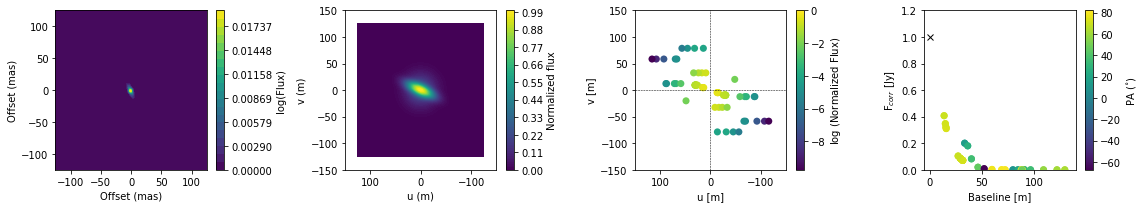

In [278]:
#interferometric observatoona from Burtscher+13
DIR = '/Users/elopezro/Documents/GitHub/agn-imaging/data/oifits_Burtscher13/'
uvfilename = DIR+'NGC1068.oifits'


npix = 250
xx = np.linspace(-npix//2,npix//2,npix)
x,y = np.meshgrid(xx,xx)

g0  = models.Gaussian2D(amplitude=1, x_mean=-1, y_mean=-1, \
                       x_stddev=2, y_stddev=2, \
                       theta=0)

g1  = models.Gaussian2D(amplitude=1, x_mean=-1, y_mean=-1, \
                       x_stddev=2*3, y_stddev=2, \
                       theta=-20)



gg = (g0(x,y) + g1(x,y))/np.sum(g0(x,y) + g1(x,y)) #normalize Gaussian

#gg = g0(x,y)/np.sum(g0(x,y)) #normalize Gaussian

#Create FFT 2D image
g_fft = inter.ima2fft(gg)
#Obtain pixel scale
#fftscale = inter.fft_pxscale(sky)
fftscale = 1 #m/px
#Obtain uv points
u,v = inter.uvload(uvfilename)
#Obtain correlated flux
ima_fft = np.abs(g_fft)   

#total flux
f_t = np.abs(np.fft.fft2(gg)[0][0])

#correlated flux
xx  = np.arange(ima_fft.shape[0])
ip = ndiminterpolation.NdimInterpolation(ima_fft,[xx,xx])
uu = u + ima_fft.shape[0]//2
vv = v + ima_fft.shape[0]//2
corrflux = ip(np.dstack((uu,vv)))

#baseline and PA
BL = np.sqrt(u**2+v**2)
Phi = np.rad2deg(np.arctan(u/v))

plot_inter(gg,g_fft,fftscale,u,v,corrflux,BL,Gaussian=True)

In [144]:
aa = fits.open(uvfilename)

In [145]:
aa.info()

Filename: /Users/elopezro/Documents/GitHub/agn-imaging/data/oifits_Burtscher13/NGC1068.oifits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  OI_ARRAY      1 BinTableHDU     28   7R x 5C   [16A, 16A, 1I, 1E, 3D]   
  2  OI_TARGET     1 BinTableHDU     56   1R x 17C   [1I, 16A, 1D, 1D, 1E, 1D, 1D, 1D, 8A, 8A, 1D, 1D, 1D, 1D, 1E, 1E, 16A]   
  3  OI_WAVELENGTH    1 BinTableHDU     18   171R x 2C   [1E, 1E]   
  4  OI_VIS        1 BinTableHDU     51   32R x 14C   [1I, 1D, 1D, 1D, 171D, 171D, 171D, 171D, 171D, 171D, 1D, 1D, 2I, 171L]   


In [253]:
aa[4].header

XTENSION= 'BINTABLE'           /Written by IDL:  Thu Jul  4 14:22:07 2013       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                 8425 /Number of bytes per row                         
NAXIS2  =                   32 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                   14 /Number of columns                               
EXTNAME = 'OI_VIS  '           /name of this binary table extension             
EXTVER  =                    1 /Extension version                               
TFORM1  = '1I      '           /Integer*2 (short integer)                       
TTYPE1  = 'TARGET_ID'          /Label for column 1                              
TFORM2  = '1D      '        

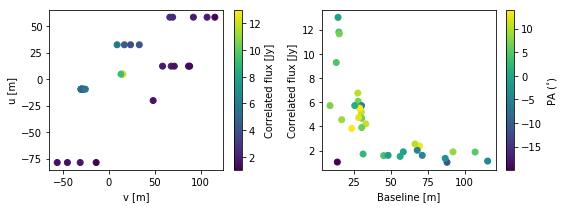

In [293]:
cflux = aa['OI_VIS'].data['CFLUX']
wave = aa['OI_WAVELENGTH'].data['EFF_WAVE']
ucoord = aa['OI_VIS'].data['UCOORD']
vcoord = aa['OI_VIS'].data['VCOORD']
visphi = aa['OI_VIS'].data['VISPHI']

ll = 12.05 #wavelength in um
cf = np.zeros(len(ucoord))
pa = np.zeros(len(ucoord))
for ii in range(len(ucoord)):
    cf[ii] = cflux[:][ii][np.where(wave <= ll*1E-6)[0][0]]
    pa[ii] = visphi[:][ii][np.where(wave <= ll*1E-6)[0][0]]

fig, axs = plt.subplots(1,2,figsize=(8,3))
ax = axs.flatten()

### uv-plane
cbar = ax[0].scatter(ucoord,vcoord,c=cf,marker='o')
plt.colorbar(cbar,label='Correlated flux [Jy]',ax=ax[0])
ax[0].set_xlabel('v [m]')
ax[0].set_ylabel('u [m]')
#ax[0].set_xlim([130,-130])
#ax[0].set_ylim([-130,130])

### Correlated flux
cbar = ax[1].scatter(np.abs(ucoord),cf,c=pa,marker='o')
plt.colorbar(cbar,label='PA ($^{\circ}$)',ax=ax[1])
ax[1].set_xlabel('Baseline [m]')
ax[1].set_ylabel('Correlated flux [Jy]')



fig.tight_layout()

array([4.36836338e+00, 1.65185699e+01, 3.96491146e+00, 4.84608173e+00,
       5.03276968e+00, 6.30084038e+00, 3.51857042e+00, 3.38746488e-01,
       1.95783901e+01, 5.31297207e+00, 8.37218189e+00, 1.07157249e+01,
       1.02135677e+01, 8.22644901e+00, 3.13115520e+01, 1.00543776e+01,
       1.13613873e+01, 4.01983490e+01, 4.89732475e+01, 3.35625172e+00,
       1.55694456e+01, 1.21769419e+01, 7.07339621e+00, 9.18842793e+00,
       1.78544865e+01, 8.02075863e+00, 2.36125259e+01, 7.19172144e+00,
       6.79010773e+00, 8.15503025e+00, 9.29623508e+00, 1.10590315e+01,
       7.39270210e+00, 6.50534010e+00, 8.34931755e+00, 8.96260929e+00,
       7.93861532e+00, 6.72828770e+00, 6.79430199e+00, 7.76185799e+00,
       7.72034121e+00, 6.29291201e+00, 7.04479504e+00, 6.66802883e+00,
       5.78098631e+00, 7.01964808e+00, 5.72690105e+00, 7.00461531e+00,
       6.63772964e+00, 6.86040592e+00, 5.51682758e+00, 6.55060387e+00,
       7.54433155e+00, 6.61473179e+00, 6.49080706e+00, 5.69571209e+00,
      